<a href="https://colab.research.google.com/github/viswambhar-yasa/image_captioning/blob/master/training_reward_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/viswambhar-yasa/image_captioning

Cloning into 'image_captioning'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 22 (delta 8), reused 15 (delta 4), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [2]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile


def downloading_extraction(link, extraction_path='.'):
    url = urlopen(link)
    zipfile = ZipFile(BytesIO(url.read()))
    zipfile.extractall(path=extraction_path)


if __name__ == "__main__":
    images_link = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'
    downloading_extraction(images_link)
    text_link = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
    downloading_extraction(text_link)


In [156]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Embedding, LSTM, BatchNormalization, Bidirectional
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers.recurrent import GRU


def image_encoder(img_input, trainable_layers=0, CNN_Type='Xception', Embed_Size=256, display=False):
    print('Building CNN model')
    if CNN_Type == 'Xception':
        cnn_pre_trained_model = Xception(include_top=False, weights='imagenet', input_tensor=img_input)
    else:
        cnn_pre_trained_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=img_input)
    for i, layer in enumerate(cnn_pre_trained_model.layers):
        if len(cnn_pre_trained_model.layers) - i < trainable_layers:
            layer.trainable = True
        else:
            layer.trainable = False
    cnn_inputs = cnn_pre_trained_model.inputs
    base_model = cnn_pre_trained_model.output
    base_model = GlobalAveragePooling2D(name='global_average_pooling')(base_model)
    embed_image = tf.keras.layers.Dense(Embed_Size, activation='tanh', name='embed_image')(base_model)
    feature_extraction_model = Model(inputs=cnn_inputs, outputs=embed_image, name='CNN encoder model')
    print('CNN model {output shape}:', embed_image.shape)
    if display:
        tf.keras.utils.plot_model(feature_extraction_model, to_file='base_model.png', show_shapes=True)
    return feature_extraction_model


def txt_decoder(rnn_input, Embed_Size=256, Bi_Direction=False, RNN_Type='LSTM', RNN_Layers=2):
    print('Building RNN model')
    for i in range(RNN_Layers):
        x = BatchNormalization()(rnn_input)
        if RNN_Type == 'LSTM':
            if i == (RNN_Layers - 1):
                if Bi_Direction:
                    rnn_out = Bidirectional(LSTM(int(Embed_Size/2)))(x)
                else:
                    rnn_out = LSTM(Embed_Size)(x)
            else:
                if Bi_Direction:
                    rnn_out = Bidirectional(LSTM(int(Embed_Size/2), return_sequences=True))(x)
                else:
                    rnn_out = LSTM(Embed_Size, return_sequences=True)(x)
        else:
            if i == (RNN_Layers - 1):
                if Bi_Direction:
                    rnn_out = Bidirectional(GRU(Embed_Size))(x)
                else:
                    rnn_out = GRU(Embed_Size)(x)
            else:
                if Bi_Direction:
                    rnn_out = Bidirectional(GRU(Embed_Size/2, return_sequences=True))(x)
                else:
                    rnn_out = GRU(Embed_Size, return_sequences=True)(x)
        rnn_input = rnn_out
    return rnn_out


def Caption_model_gen(NET, img_shape=(256, 256, 3), vocab_size=8763, Embed_Size=512, max_length=20, display=False):
    img_input = tf.keras.Input(shape=img_shape)
    cnn_model = image_encoder(img_input, trainable_layers=0, CNN_Type='InceptionV3', display=False)
    embed_image = tf.keras.layers.Dense(Embed_Size, activation='tanh')(cnn_model.output)

    text_input = tf.keras.Input(shape=(max_length,))
    Embedding_layer = Embedding(input_dim=vocab_size, output_dim=Embed_Size, input_length=max_length, mask_zero=True)(
        text_input)

    whole_seq_output = txt_decoder(Embedding_layer, Embed_Size=Embed_Size,
                                                                          Bi_Direction=False, RNN_Type='LSTM',
                                                                          RNN_Layers=1)
    print('final_carry_state {rnn output shape}:', whole_seq_output.shape)
    rnn_output = whole_seq_output
    if NET == 'policy':
        image_txt_embed = tf.keras.layers.add([embed_image, rnn_output])
        print('Image and text {add shape}:', image_txt_embed.shape)
        policy_net_output = tf.keras.layers.Dense(vocab_size, activation='softmax')(image_txt_embed)
        policy_net_model = Model(inputs=[img_input, text_input], outputs=policy_net_output, name='Policy_Net')

        print('output {shape}', policy_net_output.shape)
        print('Policy Net built successfully \n')
        if display:
            tf.keras.utils.plot_model(policy_net_model, to_file='policy_net.png', show_shapes=True)
        return policy_net_model
    elif NET == 'value':
        image_txt_embed = tf.keras.layers.concatenate([embed_image, rnn_output], axis=-1)
        print('Image and text {concat shape}:', image_txt_embed.shape)
        hidden_layer_1 = Dense(1024, activation='tanh', name='MLP_layer1')(image_txt_embed)
        hidden_layer_2 = Dense(512, activation='tanh', name="MLP_layer2")(hidden_layer_1)
        value_net_outputs = Dense(1, activation='tanh', name='decoder_output')(hidden_layer_2)
        value_net_model = Model(inputs=[img_input, text_input], outputs=value_net_outputs, name='Value_Net')
        print('output {shape}', value_net_outputs.shape)
        print('Value Net built successfully \n')
        if display:
            tf.keras.utils.plot_model(value_net_model, to_file='value_net.png', show_shapes=True)
        return value_net_model
    else:
        feature_vector = Dense(512, activation='tanh')(embed_image)
        text_sequence_vector = Dense(512, activation='tanh', name='rnn_linear')(rnn_output)
        print('Image feature vector shape:', feature_vector.shape)
        print('Text sequence vector shape:', text_sequence_vector.shape)
        reward_model = Model(inputs=[img_input, text_input], outputs=[feature_vector, text_sequence_vector],
                             name='reward_net_model')
        print('Reward Net built successfully \n')
        if display:
            tf.keras.utils.plot_model(reward_model, to_file='reward_net.png', show_shapes=True)
        return reward_model


if __name__ == "__main__":
    print('TensorFlow Version', tf.__version__)
    #actor_model = Caption_model_gen('policy')
    #critic_model = Caption_model_gen('value')
    #reward = Caption_model_gen('reward')


TensorFlow Version 2.7.0


In [157]:
cd /content/image_captioning

/content/image_captioning


In [158]:
import tensorflow as tf

class data_processing:
    def __init__(self, text_file_path):
        self.text_file_path = text_file_path
        self.tokenizer = None

    def extraction_captions(self, images_id_text):
        description_map = dict()
        text = open(self.text_file_path, 'r', encoding='utf-8').read()
        images = open(images_id_text, 'r', encoding='utf-8').read()
        img_dic = []
        for img_id in images.split('\n'):
            img_dic.append(img_id)
        for lines in text.split('\n'):
            line_split = lines.split('\t')
            if line_split == ['']:
                continue
            image_id = line_split[0][:-2]
            image_des = line_split[1]
            if image_id in img_dic:
                if image_id not in description_map:
                    description_map[image_id] = list()
                description_map[image_id].append(image_des)
        return description_map

    def cleaning_sequencing_captions(self, images_id_text):
        captions_dic = self.extraction_captions(images_id_text)
        caption_list = []
        for img_id, des_list in captions_dic.items():
            for i in range(len(des_list)):
                caption = des_list[i]
                caption = ''.join(caption)
                caption = caption.split(' ')
                caption = [word.lower() for word in caption if len(word) > 1 and word.isalpha()]
                caption = ' '.join(caption)
                des_list[i] = 'startseq ' + caption + ' endseq'
                caption_list.append('startseq ' + caption + ' endseq')
        max_length = max(len(des.split()) for des in caption_list)
        print('max_length of captions', max_length)
        return caption_list,captions_dic

    def tokenization(self, captions_for_token, num_wrds=5000) -> None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_wrds, oov_token='<unknw>')
        tokenizer.fit_on_texts(captions_for_token)
        self.tokenizer = tokenizer
        pass

    def sentence_tokenizing(self, captions_dic) -> dict:
        token_cap_dic = dict()
        print('Vocab size', self.tokenizer.num_words)
        for img_id, des_list in captions_dic.items():
            for i in range(len(des_list)):
                caption = des_list[i]
                cap_token = self.tokenizer.texts_to_sequences([str(caption)])
                if img_id not in token_cap_dic:
                    token_cap_dic[img_id] = list()
                token_cap_dic[img_id].append(cap_token)
        return token_cap_dic

In [159]:
text = open('/content/Flickr8k.token.txt', 'r', encoding='utf-8').read()
description_map=dict()
for lines in text.split('\n'):
  line_split = lines.split('\t')
  if line_split == ['']:
      continue
  image_id = line_split[0][:-2]
  image_des = line_split[1]
  #if image_id in img_dic:
  if image_id not in description_map:
    description_map[image_id] = list()
  description_map[image_id].append(image_des)
caption_list = []
for img_id, des_list in description_map.items():
    for i in range(len(des_list)):
        caption = des_list[i]
        caption = ''.join(caption)
        caption = caption.split(' ')
        caption = [word.lower() for word in caption if len(word) > 1 and word.isalpha()]
        caption = ' '.join(caption)
        des_list[i] = 'startseq ' + caption + ' endseq'
        caption_list.append('startseq ' + caption + ' endseq')
max_length = max(len(des.split()) for des in caption_list)
print('max_length of captions', max_length)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000,oov_token='<unknw>')
tokenizer.fit_on_texts(caption_list)

max_length of captions 33


In [161]:
import os
files=os.listdir(path = '/content/Flicker8k_Dataset')

In [163]:
description_map1=dict()
for key,value in description_map.items():
  if key in files:
    description_map1[key]=value

In [119]:
description_map['2258277193_586949ec62.jpg'] = description_map['2258277193_586949ec62.jpg.1']
del description_map['2258277193_586949ec62.jpg.1']

In [160]:
del description_map['2258277193_586949ec62.jpg']

KeyError: ignored

In [164]:
token_cap_dic = dict()
print('Vocab size',len(tokenizer.word_counts))
for img_id, des_list in description_map1.items():
    for i in range(len(des_list)):
        caption = des_list[i]
        cap_token = tokenizer.texts_to_sequences([str(caption)])
        if img_id not in token_cap_dic:
            token_cap_dic[img_id] = list()
        token_cap_dic[img_id].append(cap_token)

Vocab size 8359


In [165]:
def reward_net_loss(visual_features,sematic_featurres,margin=0.2):
    #bi-directional max-margin ranking loss (Bi-MMRL)
    #visual=tf.ones(shape=(32,512))
    #sematic=tf.ones(shape=(32,512))
    B=visual_features.shape[0]
    remove_diagonal_matrix=tf.ones(B)-tf.eye(B)
    similarity_score_1=tf.einsum("ij,kj->ik",visual_features,sematic_featurres)
    similarity_score_2=tf.einsum("ij,kj->ki",visual_features,sematic_featurres)
    diagonal=tf.einsum("ii->i",similarity_score_1)
    s_ii=tf.eye(B)*tf.transpose(diagonal)
    loss1=tf.reduce_sum(tf.maximum(0,margin+(similarity_score_1*remove_diagonal_matrix)-s_ii))
    loss2=tf.reduce_sum(tf.maximum(0,margin+(similarity_score_2*remove_diagonal_matrix)-s_ii))
    rn_loss=(loss1+loss2)*(1/B)
    #birectional hard-negatives ranking loss (Bi-HNRL)
    #loss1=tf.reduce_sum(tf.maximum(0,margin+(tf.eye(B)*tf.transpose(tf.argmax(similarity_score_1)))-s_ii))
    #loss2=tf.reduce_sum(tf.maximum(0,margin+(tf.eye(B)*tf.transpose(tf.argmax(similarity_score_2)))-s_ii))
    #loss=loss1+loss2
    #loss
    return rn_loss

In [239]:
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import numpy as np
from data_processing import data_processing


def load_preprocess_img(img_path):
    img = load_img(img_path, target_size=(256, 256, 3))
    x = img_to_array(img)
    x /= 255.0
    return x


def captions_generation_reward(captions_dic, vocab_size, image_pth_rt, max_length=25, num_photos_per_batch=5, num_captions=1):
    images, input_text_seq = list(), list()
    batch_iter = 0
    batch_keys = []
    while True:
        for key, desc_list in captions_dic.items():
            # print(key)
            batch_keys.append(key)
            batch_iter += 1
            caption = 0
            # retrieve the photo feature
            photo = load_preprocess_img(image_pth_rt + key)
            for desc in desc_list:
                desc = np.squeeze(desc)
                input_sequence=[]
                for i in range(0, len(desc)-1):
                    input_sequence.append(desc[:i+1])
                    images.append(photo)
                caption += 1
                input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_sequence, maxlen=max_length,
                                                                          padding='post')
                input_text_seq.append(input_seq)
                if caption == num_captions:
                    break
            if batch_iter == num_photos_per_batch:
                input_text_seq = np.concatenate(input_text_seq)
                yield [np.array(images), np.array(input_text_seq)]
                images, input_text_seq = list(), list()
                batch_iter = 0

In [242]:
import tensorflow as tf
#from data_processing import data_processing
#from data_generator import captions_generation
import pickle

print('TensorFlow Version', tf.__version__)
vocab_size = 5000
max_length = 25


captions_text_path = r'/content/Flickr8k.token.txt'
captions_extraction = data_processing(captions_text_path)
trn_images_id_text = r'/content/Flickr_8k.trainImages.txt'
train_cleaned_seq, train_cleaned_dic = captions_extraction.cleaning_sequencing_captions(trn_images_id_text)
val_images_id_text = r'/content/Flickr_8k.devImages.txt'
val_cleaned_seq, val_cleaned_dic = captions_extraction.cleaning_sequencing_captions(val_images_id_text)
test_images_id_text = r'/content/Flickr_8k.testImages.txt'
test_cleaned_seq, test_cleaned_dic = captions_extraction.cleaning_sequencing_captions(test_images_id_text)
captions_extraction.tokenization(train_cleaned_seq, vocab_size)
print("No of captions: Training-" + str(len(train_cleaned_seq) / 5) + " Validation-" + str(
    len(val_cleaned_seq) / 5) + " test-" + str(len(test_cleaned_seq) / 5))

train_cap_tok = captions_extraction.sentence_tokenizing(train_cleaned_dic)
val_cap_tok = captions_extraction.sentence_tokenizing(val_cleaned_dic)
test_cap_tok = captions_extraction.sentence_tokenizing(test_cleaned_dic)

image_pth_rt = r"/content/Flicker8k_Dataset/" #+ r"\\"
trn_dataset = captions_generation_reward(train_cap_tok, vocab_size, image_pth_rt, max_length,num_photos_per_batch=2,num_captions=1)
val_dataset = captions_generation_reward(val_cap_tok, vocab_size, image_pth_rt, max_length)

inputs = next(iter(val_dataset))
print(inputs[0].shape, inputs[1].shape)

TensorFlow Version 2.7.0
max_length of captions 33
max_length of captions 31
max_length of captions 30
No of captions: Training-6000.0 Validation-1000.0 test-1000.0
Vocab size 5000
Vocab size 5000
Vocab size 5000
(47, 256, 256, 3) (47, 25)


In [223]:
trn_dataset_whole = captions_generation_reward(token_cap_dic, vocab_size, image_pth_rt, max_length,num_photos_per_batch=5,num_captions=5)

In [196]:
reward_model = Caption_model_gen(NET='reward', vocab_size=5000, Embed_Size=512, max_length=max_length,display=True)
#actor_model.summary()
#reward_model.compile(loss=reward_net_loss,                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),                    metrics=['accuracy'])

Building CNN model
CNN model {output shape}: (None, 256)
Building RNN model
final_carry_state {rnn output shape}: (None, 512)
Image feature vector shape: (None, 512)
Text sequence vector shape: (None, 512)
Reward Net built successfully 



In [197]:
def loss(image_encoder,caption_encoder):
    gamma=0.2
    N,D=image_encoder.shape
    img_encode = image_encoder
    cap_encode = caption_encoder
    scores_matrix = tf.matmul(img_encode,tf.transpose(cap_encode))
    diagonal = tf.linalg.diag_part(scores_matrix)
    cost_cap = tf.maximum(0.0, gamma - diagonal + scores_matrix)
    diagonal = tf.reshape(diagonal, [-1, 1])
    cost_img = tf.maximum(0.0, gamma - diagonal + scores_matrix)
    cost_cap = tf.linalg.set_diag(cost_cap, [0]*N)
    cost_img = tf.linalg.set_diag(cost_img, [0]*N)
    loss = tf.reduce_sum(cost_img) + tf.reduce_sum(cost_cap)
    return loss

In [198]:
loss(visuals,semantics)

<tf.Tensor: shape=(), dtype=float32, numpy=396.80002>

In [199]:
def cos(img_encode, cap_encode):
    inner_product = tf.reduce_sum(tf.multiply(img_encode, cap_encode), axis=1)
    norm1 = tf.sqrt(tf.reduce_sum(tf.square(img_encode), axis=1))
    norm2 = tf.sqrt(tf.reduce_sum(tf.square(cap_encode), axis=1))
    cos = inner_product / (norm1 * norm2)
    return cos

In [200]:
def Rewards(reward_model,input):
    visEmbeds, semEmbeds = reward_model(input)
    inner_product = tf.reduce_sum(tf.multiply(visEmbeds, semEmbeds), axis=1)
    norm1 = tf.sqrt(tf.reduce_sum(tf.square(visEmbeds), axis=1))
    norm2 = tf.sqrt(tf.reduce_sum(tf.square(semEmbeds), axis=1))
    cos = inner_product / (norm1 * norm2)
    print(cos)
    return cos

In [201]:
#reward_model1=tf.keras.models.load_model('/content/drive/MyDrive/Kaggle/reward_net.h5')

In [202]:
#reward_model.save('/content/drive/MyDrive/Kaggle/reward_net.h5')

In [203]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
history={}
history['loss']=list()
history['val_loss']=list()
metrics_names = ['loss'] 
epochs = 1
num_epoch=400
for i in range(epochs):
    n=0
    epoch=0
    for step, x_batch_train in enumerate(trn_dataset_whole):
        if epoch==num_epoch:
          break
        progbar = tf.keras.utils.Progbar(10,stateful_metrics=['loss'])

        with tf.GradientTape() as tape:

            [visual,sematic] = reward_model(x_batch_train, training=True)  # Logits for this minibatch
            loss_value = loss(visual, sematic)
        grads = tape.gradient(loss_value, reward_model.trainable_weights)

        optimizer.apply_gradients(zip(grads, reward_model.trainable_weights))
        progbar.update(n, values = [("loss", loss_value)])
        # Log every 200 batches.
        n+=1
        if step % 10 == 0:
            epoch+=1
            val_ds=next(iter(val_dataset))
            [val_visual,val_sematic] = reward_model(val_ds)
            val_loss_value=loss(val_visual, val_sematic)
            progbar.add(1,values = [("val_loss", val_loss_value)])
            n=0
            print("\nepoch %d" % (epoch,))
            history['loss'].append(loss_value)
            history['val_loss'].append(val_loss_value)


 1/10 [==>...........................] - ETA: 4s - loss: 33.8575 - val_loss: 8.7390
epoch 1
10/10 [==============================] - 0s 41ms/step - loss: 44.3347 - val_loss: 9.4053

epoch 2
10/10 [==============================] - 0s 42ms/step - loss: 27.4112 - val_loss: 9.6651

epoch 3
10/10 [==============================] - 0s 40ms/step - loss: 27.5526 - val_loss: 8.6949

epoch 4
10/10 [==============================] - 0s 41ms/step - loss: 10.3849 - val_loss: 8.2126

epoch 5
10/10 [==============================] - 0s 40ms/step - loss: 9.8615 - val_loss: 8.3936

epoch 6
10/10 [==============================] - 0s 42ms/step - loss: 8.1175 - val_loss: 8.2235

epoch 7
10/10 [==============================] - 0s 41ms/step - loss: 7.9886 - val_loss: 8.0852

epoch 8
10/10 [==============================] - 0s 40ms/step - loss: 7.9863 - val_loss: 8.3172

epoch 9
10/10 [==============================] - 0s 40ms/step - loss: 7.9949 - val_loss: 8.6909

epoch 10
10/10 [=======================

In [204]:
f = open("/content/reward_net_whole_training_lstm_1.pkl", "wb")
pickle.dump(history, f)
f.close()   

In [206]:
import matplotlib.pyplot as plt

(150.0, 250.0, 0.0, 25.0)

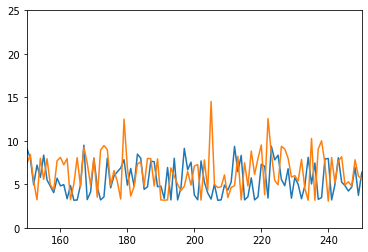

In [208]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.axis([150,250,0,25])

In [205]:
reward_model.save('/content/drive/MyDrive/Kaggle/reward_net.h5')

In [243]:
inputs = next(iter(trn_dataset))
print(inputs[0].shape, inputs[1].shape)

(23, 256, 256, 3) (23, 25)


In [244]:
Rewards(reward_model,[inputs[0], inputs[1]])

tf.Tensor(
[-0.1714517  -0.08112587 -0.0421367  -0.07938948 -0.06951115  0.00896424
 -0.07128771  0.00073981  0.05484186 -0.0505094  -0.02855068  0.04097078
 -0.06991029 -0.03773518 -0.09498962 -0.18582702 -0.12046738  0.13599293
  0.03389726  0.00137834  0.06450967  0.09902795  0.06705884], shape=(23,), dtype=float32)


<tf.Tensor: shape=(23,), dtype=float32, numpy=
array([-0.1714517 , -0.08112587, -0.0421367 , -0.07938948, -0.06951115,
        0.00896424, -0.07128771,  0.00073981,  0.05484186, -0.0505094 ,
       -0.02855068,  0.04097078, -0.06991029, -0.03773518, -0.09498962,
       -0.18582702, -0.12046738,  0.13599293,  0.03389726,  0.00137834,
        0.06450967,  0.09902795,  0.06705884], dtype=float32)>

In [ ]:
#reward_model.save('/content/drive/MyDrive/Kaggle/reward_net.h5')

In [ ]:
reward_model=tf.keras.models.load_model('/content/drive/MyDrive/Kaggle/reward_net.h5')
#actor_model.summary()
#reward_model.compile(loss=reward_net_loss,                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),                    metrics=['accuracy'])

In [43]:
inputs = next(iter(val_dataset))
print(inputs[0].shape, inputs[1].shape)

(5, 256, 256, 3) (5, 25)


In [44]:
r=Rewards(reward_model,[inputs[0], inputs[1]])

tf.Tensor([0.31575733 0.40269744 0.40483108 0.24068792 0.21883138], shape=(5,), dtype=float32)


In [ ]:
'/content/drive/MyDrive/Kaggle/reward_net.h5'

In [ ]:
history.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
f = open("/content/history_reward_model_Adam_incp_lstm_3.pkl", "wb")
pickle.dump(history, f)
f.close() 

In [ ]:
reward_model.save_weights('/content/reward_net_model_weights.h5')

In [ ]:
def Rewards(model,features, captions):
    visEmbeds, semEmbeds = model(features, captions)
    visEmbeds=tf.norm
    visEmbeds = F.normalize(visEmbeds, p=2, dim=1) 
    semEmbeds = F.normalize(semEmbeds, p=2, dim=1) 
    rewards = torch.sum(visEmbeds*semEmbeds, axis=1).unsqueeze(1)
    return rewards